# View GCaMP mismatch closed and open loop data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from harp_resources import process, utils
from analysis_functions import *
import matplotlib.patches as patches
import seaborn as sns

In [6]:
G8_MM_1 = pd.read_csv('G8_MMclosed_open_session1.csv', dtype=dtype_dict)
G8_MM_2 = pd.read_csv('G8_MMclosed_open_session2.csv', dtype=dtype_dict)

In [7]:
# Chaning event name to halt and making it so that its True when there is a halt
#G8_MM_1.loc[:, 'event'] = G8_MM_1['event'].replace({False: True, True: False})
G8_MM_1.rename(columns = {'event': 'halt'}, inplace = True)
G8_MM_2.rename(columns = {'event': 'halt'}, inplace = True)


In [8]:
#Make sure the index provides inforamtion of seconds since start
G8_MM_1.set_index('Seconds', inplace=True)
G8_MM_2.set_index('Seconds', inplace=True)
# Theres only photomotry information from 15 seconds due to bleaching
G8_MM_1 = G8_MM_1.loc[ G8_MM_1.index>30]
G8_MM_2 = G8_MM_2.loc[ G8_MM_2.index>30]

In [82]:
def view_session_mouse(mousedata_dict, mouse):
    print('\033[1m' + f'Plotted traces for {mouse}' + '\033[0m')
    
    plotlist = ['470_dfF', 'movementX']
    fig, ax = plt.subplots(len(plotlist), len(mousedata_dict), figsize=(15, 10), sharex=True)  # sharex=True for a shared x-axis
    
    for s, (session, session_data) in enumerate(mousedata_dict.items()):
        
        # Getting the mouse-specific data from the session
        time = session_data.index
        event = session_data.halt
        color = ['forestgreen', 'blue']
    
        # Iterate over the traces in plotlist and plot each on a new row
        for i, trace in enumerate(plotlist):
            ax[i, s].plot(time, session_data[trace], color=color[i])
            ax[i, s].set_title(f"{trace} - {session}")
            
            # Plot shaded areas for each halt event
            ymin, ymax = ax[i, s].get_ylim()
            halt = ax[i, s].fill_between(time, ymin, ymax, where=event, color='grey', alpha=0.3)
        
        # Plot annotations for different blocks
        block_colors = ['lightsteelblue', 'lightcoral', 'forestgreen']
        colorcount = 0
        for col in session_data:
            if '_block' in col:
                start = session_data.loc[session_data[col] == True].index[0]
                end = session_data.loc[session_data[col] == True].index[-1]
        
                min_time, max_time = ax[0, s].get_xlim()
                norm_start = norm(start, min_time, max_time)
                norm_end = norm(end, min_time, max_time)
                
                # Add rectangles with alpha=0.1 to each trace subplot in this session
                for i in range(len(plotlist)):
                    ax[i, s].add_patch(Rectangle(
                        (norm_start, 0), norm_end - norm_start, 1, 
                        facecolor=block_colors[colorcount], alpha=0.1, clip_on=False, transform=ax[i, s].transAxes
                    ))

                # Add labels at the bottom of the last plot
                ax[-1, s].text(norm_start + 0.05, -0.2, col, transform=ax[-1, s].transAxes,
                               fontsize=10, verticalalignment='top')
                ax[-1, s].add_patch(Rectangle(
                    (norm_start, -0.15), norm_end - norm_start, -0.2, 
                    facecolor=block_colors[colorcount], alpha=0.5, clip_on=False, transform=ax[-1, s].transAxes))
                
                colorcount += 1

    halt.set_label('halts')
    # Create one legend for the figure
    fig.legend(fontsize=12)
    
    # Update font size and layout
    plt.rcParams.update({'font.size': 10})
    fig.tight_layout(pad=1.08)
    plt.show()


In [83]:
#Check that the same mice are in the datsets
print(G8_MM_1.mouseID.unique())
print(G8_MM_2.mouseID.unique())


['B2M5' 'B2M4' 'B3M3' 'B3M1' 'B3M2']
['B2M5' 'B2M4' 'B3M3' 'B3M1' 'B3M2']


Plotted traces for B2M5


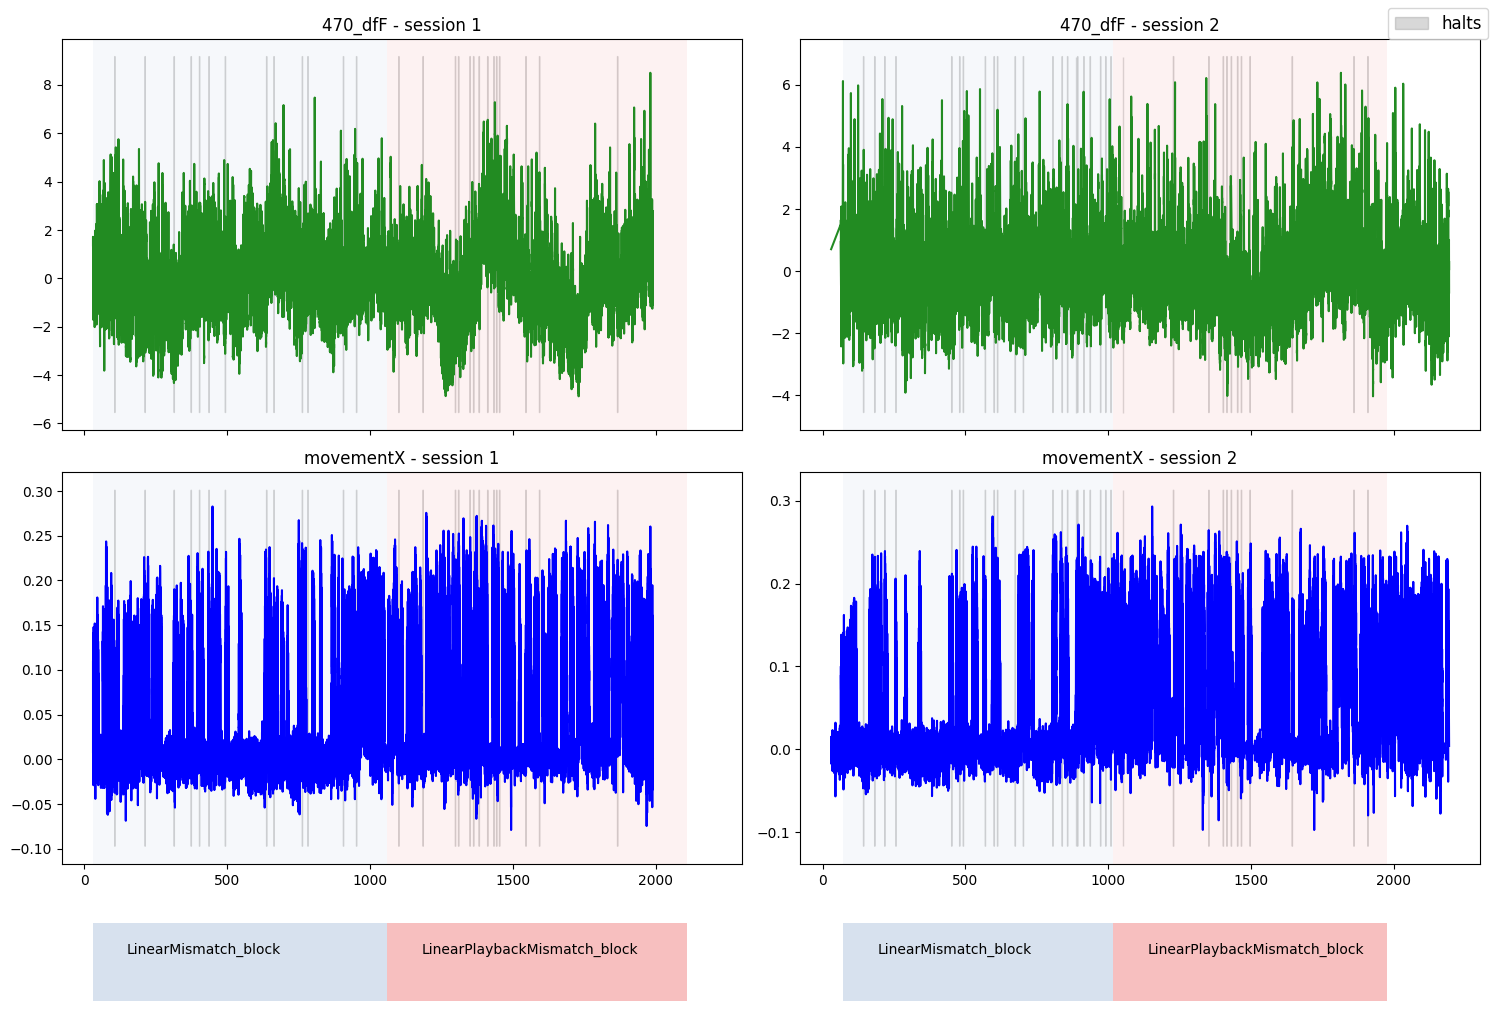

Plotted traces for B2M4


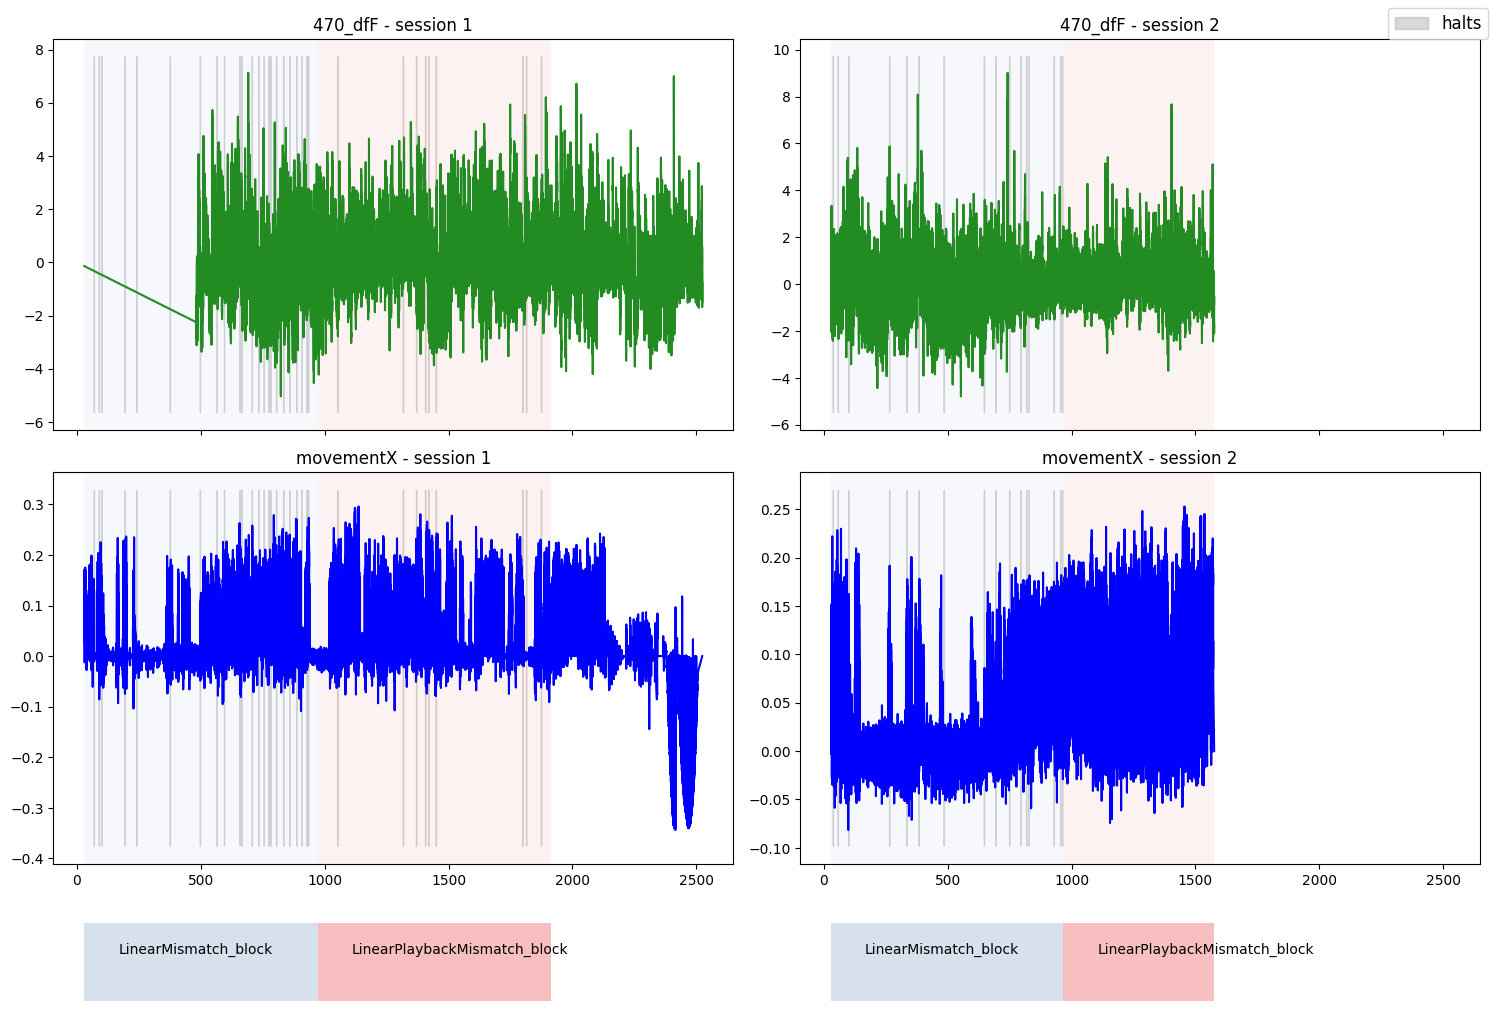

Plotted traces for B3M3


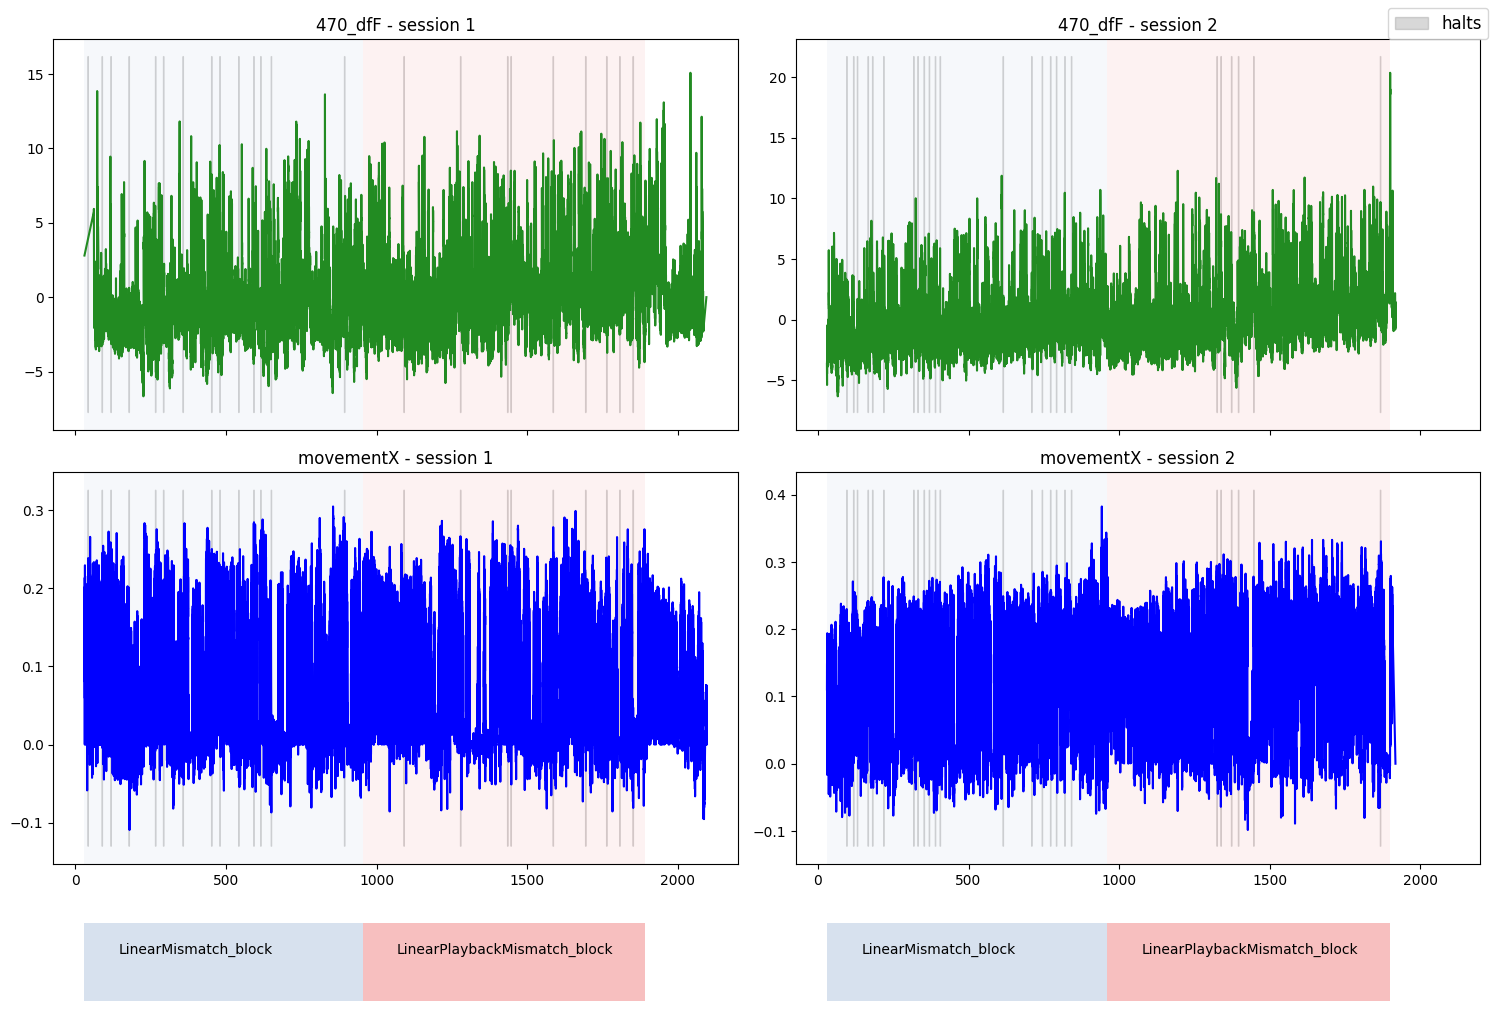

Plotted traces for B3M1


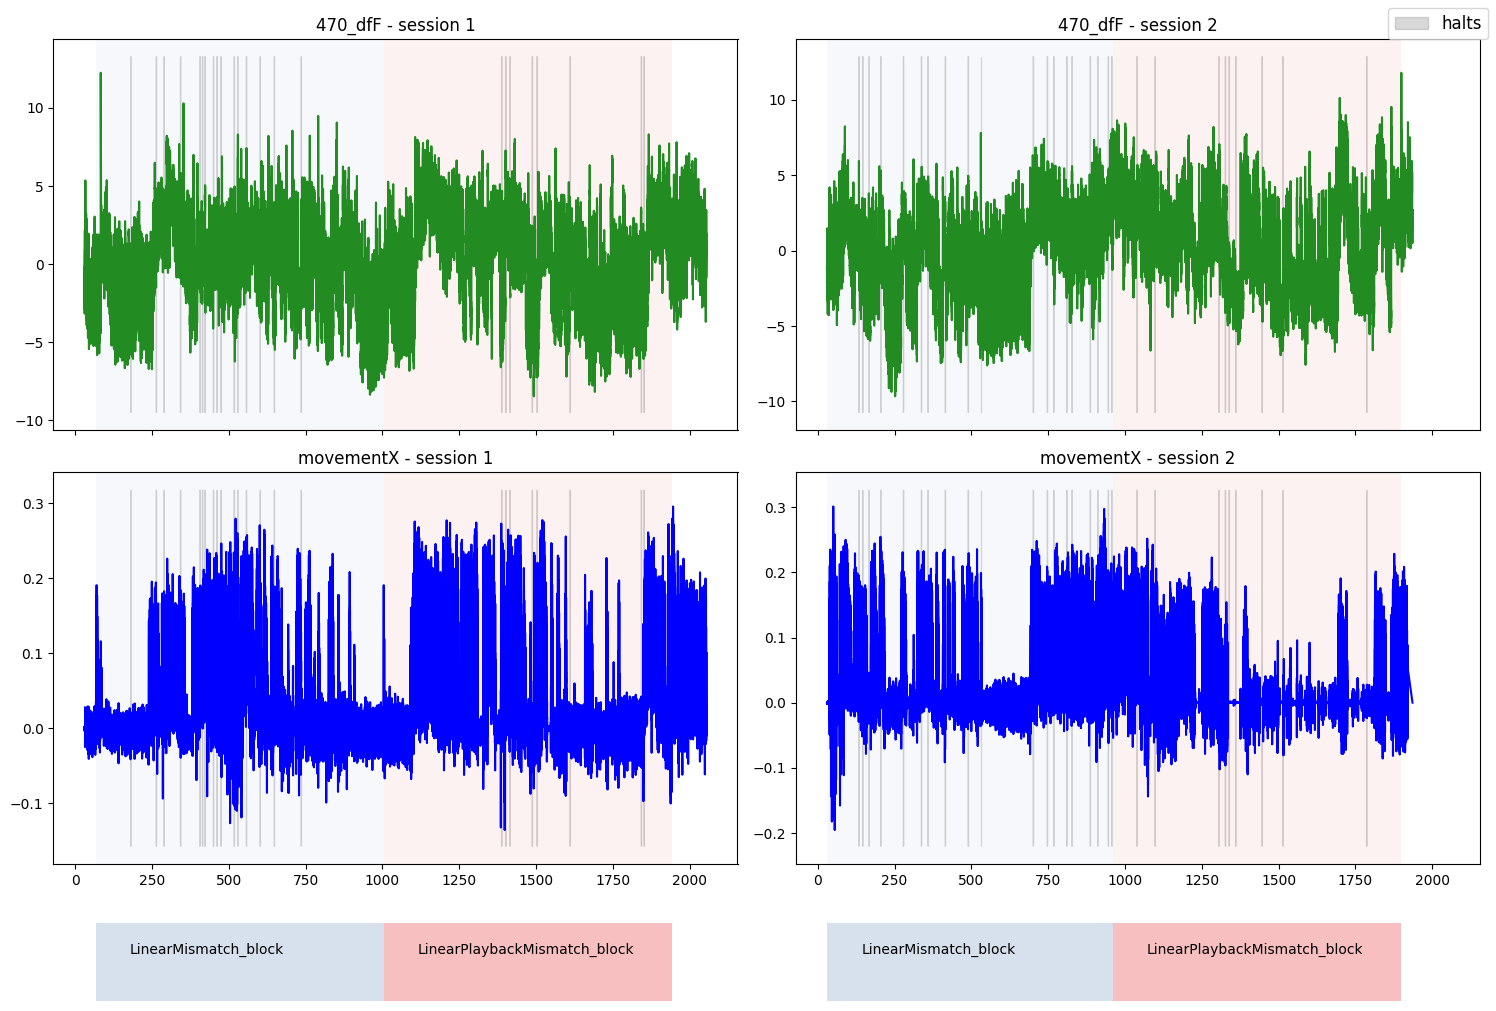

Plotted traces for B3M2


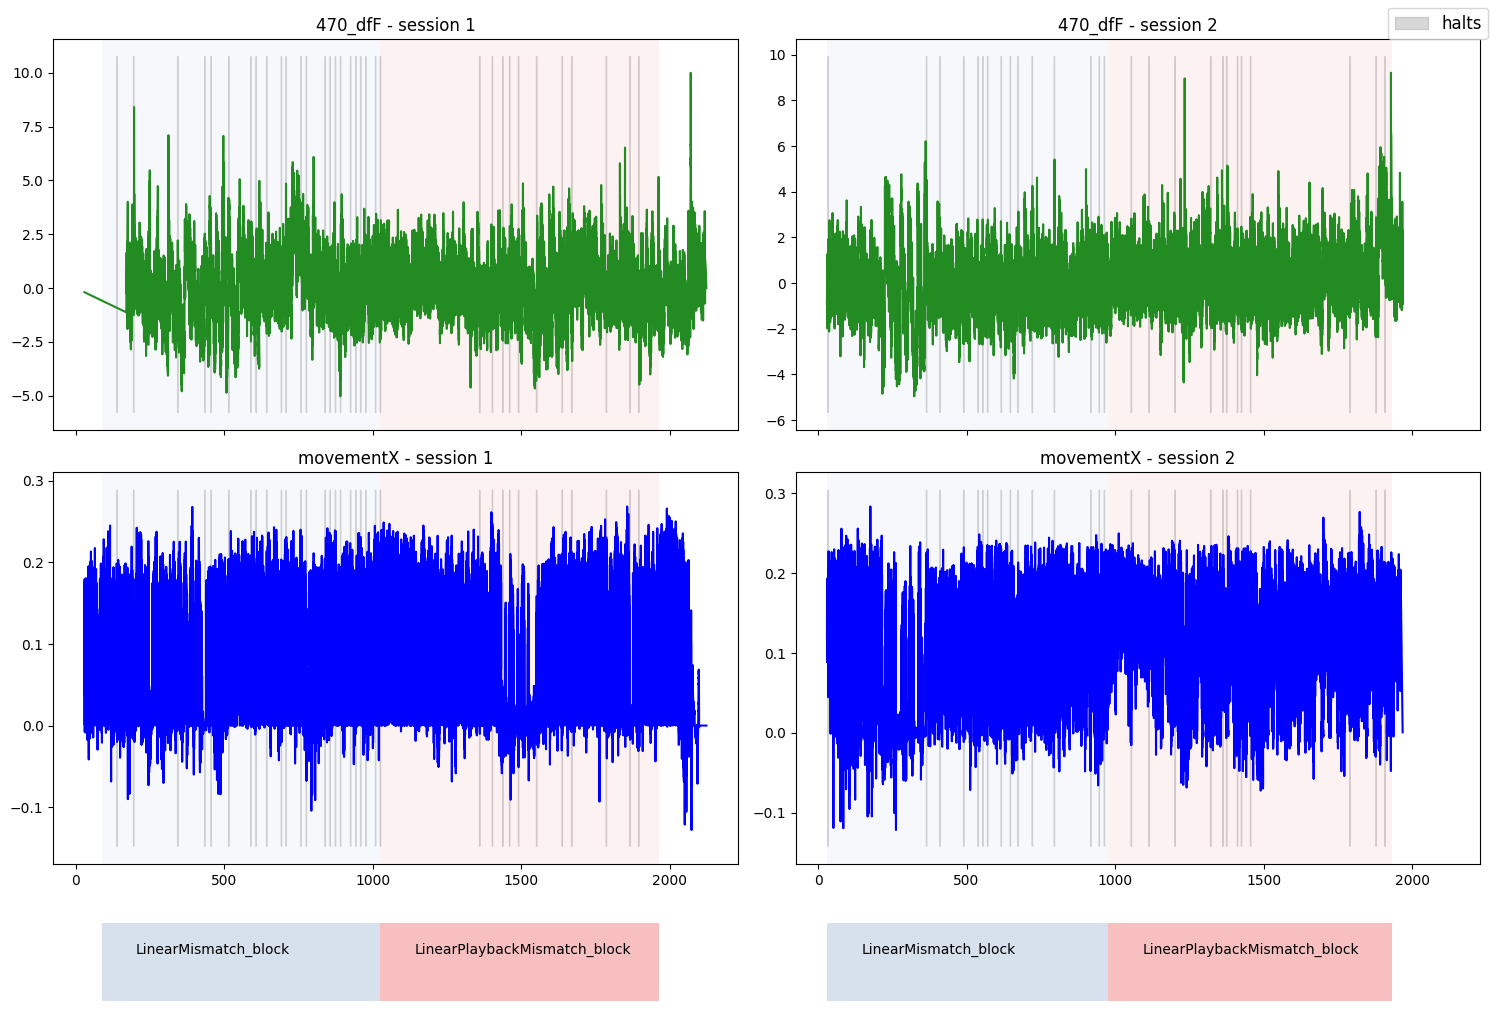

In [84]:
for mouse in G8_MM_1.mouseID.unique():
    mousedata = {'session 1':G8_MM_1.loc[G8_MM_1.mouseID == mouse], 'session 2':G8_MM_2.loc[G8_MM_2.mouseID == mouse]}
    view_session_mouse(mousedata, mouse)

In [12]:
#Filter mice to get unique indexes
mouse_data = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for mouse in G8_MM_1.mouseID.unique():
    mouse_data['session 1']['closedloop'][mouse] = filter_data(G8_MM_1, filters = [mouse, 'closed_block'])
    mouse_data['session 1']['openloop'][mouse] = filter_data(G8_MM_1, filters = [mouse, 'open_block'])
for mouse in G8_MM_2.mouseID.unique():
    mouse_data['session 2']['closedloop'][mouse] = filter_data(G8_MM_2, filters = [mouse, 'closed_block'])
    mouse_data['session 2']['openloop'][mouse] = filter_data(G8_MM_2, filters = [mouse, 'open_block'])

In [53]:
def align_to_event_start(df, trace, event_col, range_around_event):
    
    trace_chunk_list = []
    bsl_trace_chunk_list = []
    event_index_list = []
    
    # Identify the start times for each event
    event_times = df.loc[df[event_col] & ~df[event_col].shift(1, fill_value=False)].index
    
    # Calculate the time range around each event
    before_0 = range_around_event[0]
    after_0 = range_around_event[1]
    
    # Calculate the target length of each chunk based on the sampling rate
    sampling_rate = 0.001
    target_length = int(((before_0 + after_0) / sampling_rate) + 1)  # Include both ends
    Index= pd.Series(np.linspace(-range_around_event[0], range_around_event[1], target_length)) # common index
    
    for event_time in event_times:
        
        # Determine the time range for each chunk
        start = event_time - before_0
        end = event_time + after_0
        
        # Extract the chunk from the trace column
        chunk = df[trace].loc[start:end]
        
        # Normalize the index to start at -before_0
        chunk.index = (chunk.index - chunk.index[0]) - before_0
        # Check if the chunk is shorter than the target length
        if len(chunk) < target_length:
            # Pad the chunk with NaN values at the end to reach the target length
            padding = pd.Series([np.nan] * (target_length - len(chunk)), index=pd.RangeIndex(len(chunk), target_length))
            chunk = pd.concat([chunk, padding])
            chunk.index = Index # Getting the same index as the others
        
        # Baseline the chunk
        baselined_chunk = baseline(chunk)
        
        # Append the chunk and baselined chunk to lists
        trace_chunk_list.append(chunk.values)
        bsl_trace_chunk_list.append(baselined_chunk.values)
        event_index_list.append(event_time)  # Store the event time for use in final column names

    # Convert lists of arrays to DataFrames
    try:
        trace_chunks = pd.DataFrame(np.column_stack(trace_chunk_list), columns=event_index_list)
        bsl_trace_chunks = pd.DataFrame(np.column_stack(bsl_trace_chunk_list), columns=event_index_list)
        # Set the index as the common time range index for each chunk
        trace_chunks.index = Index
        bsl_trace_chunks.index = Index
    
        return trace_chunks, bsl_trace_chunks
    
    except ValueError:
        if len(event_times) < 1:
            print('could not align to events becasue there were none, will return nothing')
            
        return 0, 0


In [54]:
#Aligning open and closed loop block data to halt start times
mouse_aligned = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged = align_to_event_start(df, '470_dfF', 'halt',[1,2])
            mouse_aligned[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt

    

could not align to events becasue there were none, will return nothing


In [55]:
mouse_aligned

{'session 1': {'closedloop': {'B2M5':          106.104   212.120   313.886   373.535   402.552   435.851   493.151  \
   -1.000  0.111796  0.383910  3.434540 -0.313005 -2.274581 -1.429129  1.143439   
   -0.999  0.109499  0.377194  3.412857 -0.306512 -2.258788 -1.420350  1.143703   
   -0.998  0.107202  0.370478  3.391174 -0.304782 -2.242995 -1.411572  1.143967   
   -0.997  0.104906  0.363762  3.369492 -0.308874 -2.227202 -1.402794  1.144231   
   -0.996  0.102609  0.357046  3.347809 -0.312966 -2.211410 -1.394016  1.144495   
   ...          ...       ...       ...       ...       ...       ...       ...   
    1.996  0.032594  2.333347  0.794755  1.464821  0.129519  1.852578  0.212427   
    1.997  0.024552  2.340401  0.800788  1.484723  0.141379  1.840704  0.218553   
    1.998  0.024161  2.347454  0.806821  1.504624  0.159494  1.828829  0.224679   
    1.999  0.033121  2.354508  0.812854  1.524526  0.177881  1.816954  0.230821   
    2.000  0.042082  2.361561  0.818887  1.544427  0

In [56]:
len(mouse_aligned['session 1']['closedloop'].keys())

5

In [57]:
mouse_aligned_nohalt = {'session 1':{'closedloop': {},'openloop': {} }, 'session 2': {'closedloop': {},'openloop': {}}}

for session, session_dict in mouse_data.items():
    for block, mice in session_dict.items():
        for mouse, df in mice.items():
            event_alinged, bsl_event_alinged = align_to_event_start(df, '470_dfF', 'No_halt',[1,2])
            mouse_aligned_nohalt[session][block][mouse] = bsl_event_alinged  #bsl indicates that it is baselined to the last 1 second before halt


could not align to events becasue there were none, will return nothing


In [74]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

def plot_compare_blocks(block_dict, event):
    # Determine number of blocks (columns) and maximum number of mice (rows)
    num_blocks = len(block_dict)
    max_mice = max(len(mice_data) for mice_data in block_dict.values())
    
    # Set up the figure with the determined number of rows and columns
    fig, ax = plt.subplots(max_mice, num_blocks, figsize=(5 * num_blocks, 3 * max_mice), squeeze=False)
    fig.suptitle(f'{event} alignment')
    
    # Dictionary to store mean data across mice for each block
    mean_mouse_dict = {block: {} for block in block_dict.keys()}
    
    # Loop over each block and each mouse, plotting down the rows within each block column
    for col, (block_name, mice_data) in enumerate(block_dict.items()):
        color_map = plt.cm.Greys  # Grey color map for traces
        
        # Loop over each mouse in the current block
        for row, (mouse, data) in enumerate(mice_data.items()):
            try:
                color = color_map(np.linspace(0, 1, data.shape[1]))  # Assign colors for traces
    
                # Plot vertical line for event alignment
                ax[row, col].axvline(x=0, linewidth=1, color='r', linestyle='--')
                
                # Plot individual traces with shading
                for idx, trace in enumerate(data.columns):
                    ax[row, col].plot(data.index, data[trace], color='grey', alpha=0.3)
    
                # Calculate mean and standard deviation across traces
                mean_trace = data.mean(axis=1)
                mean_mouse_dict[block_name][mouse] = mean_trace
                std_trace = data.std(axis=1)
    
                # Plot mean trace and standard deviation shading
                ax[row, col].plot(mean_trace, color='black', label='Mean' if row == 0 else "")
                ax[row, col].fill_between(mean_trace.index, mean_trace - std_trace, mean_trace + std_trace, alpha=0.3)
    
                # Add a shaded rectangle for a specified range (0 to 1)
                ax[row, col].add_patch(patches.Rectangle((0, ax[row, col].get_ylim()[0]), 1, 
                                                         ax[row, col].get_ylim()[1] - ax[row, col].get_ylim()[0], 
                                                         color='grey', alpha=0.1))
                # Set title and labels for the first row
                if row == 0:
                    ax[row, col].set_title(f"{block_name} loop responses")
                if col == 0:
                    ax[row, col].set_ylabel(f"Mouse: {mouse}")
            except AttributeError:
                pass
        

    fig.tight_layout(pad=1.08)

    # Aggregate means across mice for each block
    fig, ax = plt.subplots(1, num_blocks, figsize = (5 * num_blocks, 5))
    fig.suptitle('Mean across animal means')
    
    for col, (block_name, mean_data) in enumerate(mean_mouse_dict.items()):
        # Create DataFrame from mean data and compute overall mean and std across mice
        mean_df = pd.DataFrame.from_dict(mean_data)
        overall_mean = mean_df.mean(axis=1)
        overall_std = mean_df.std(axis=1)
        
        # Plot mean across animals with standard deviation shading
        ax[col].axvline(x=0, linewidth=1, color='r', linestyle='--')
        ax[col].plot(overall_mean, color='black')
        ax[col].fill_between(overall_mean.index, overall_mean - overall_std, overall_mean + overall_std, alpha=0.3)
        
        # Add rectangle to highlight the specified region (e.g., 0 to 1)
        ax[col].add_patch(patches.Rectangle((0, ax[col].get_ylim()[0]), 1, 
                                            ax[col].get_ylim()[1] - ax[col].get_ylim()[0], 
                                            color='grey', alpha=0.1))
        
        # Set title for each block
        ax[col].set_title(f'{block_name} loop mean response')

    return mean_mouse_dict


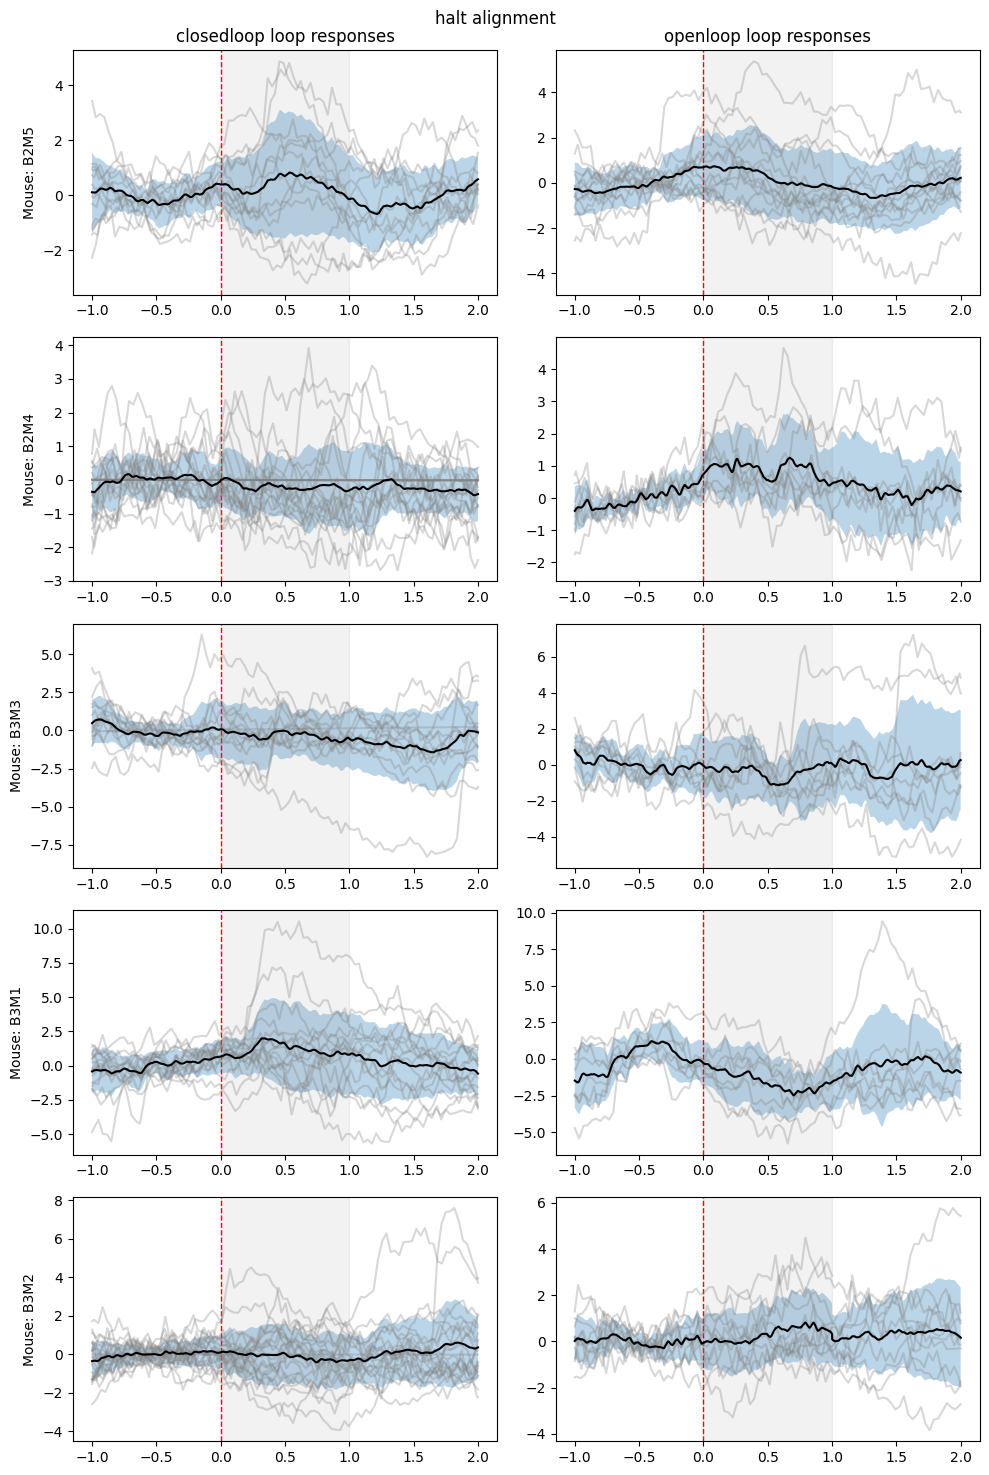

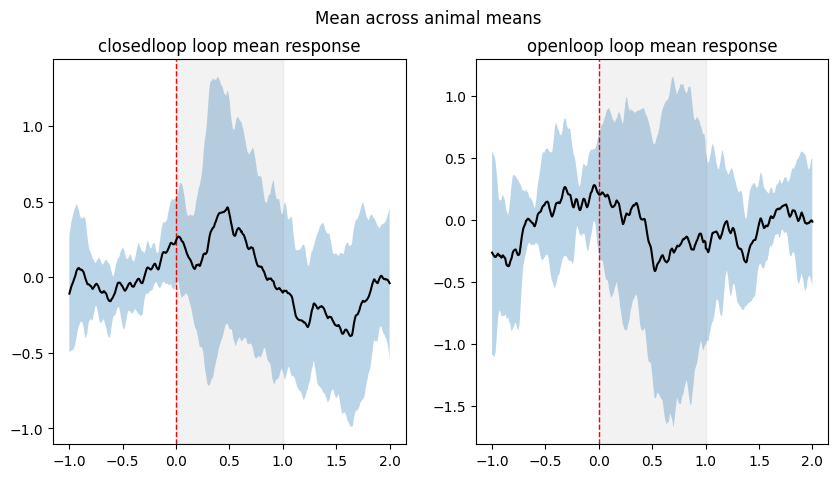

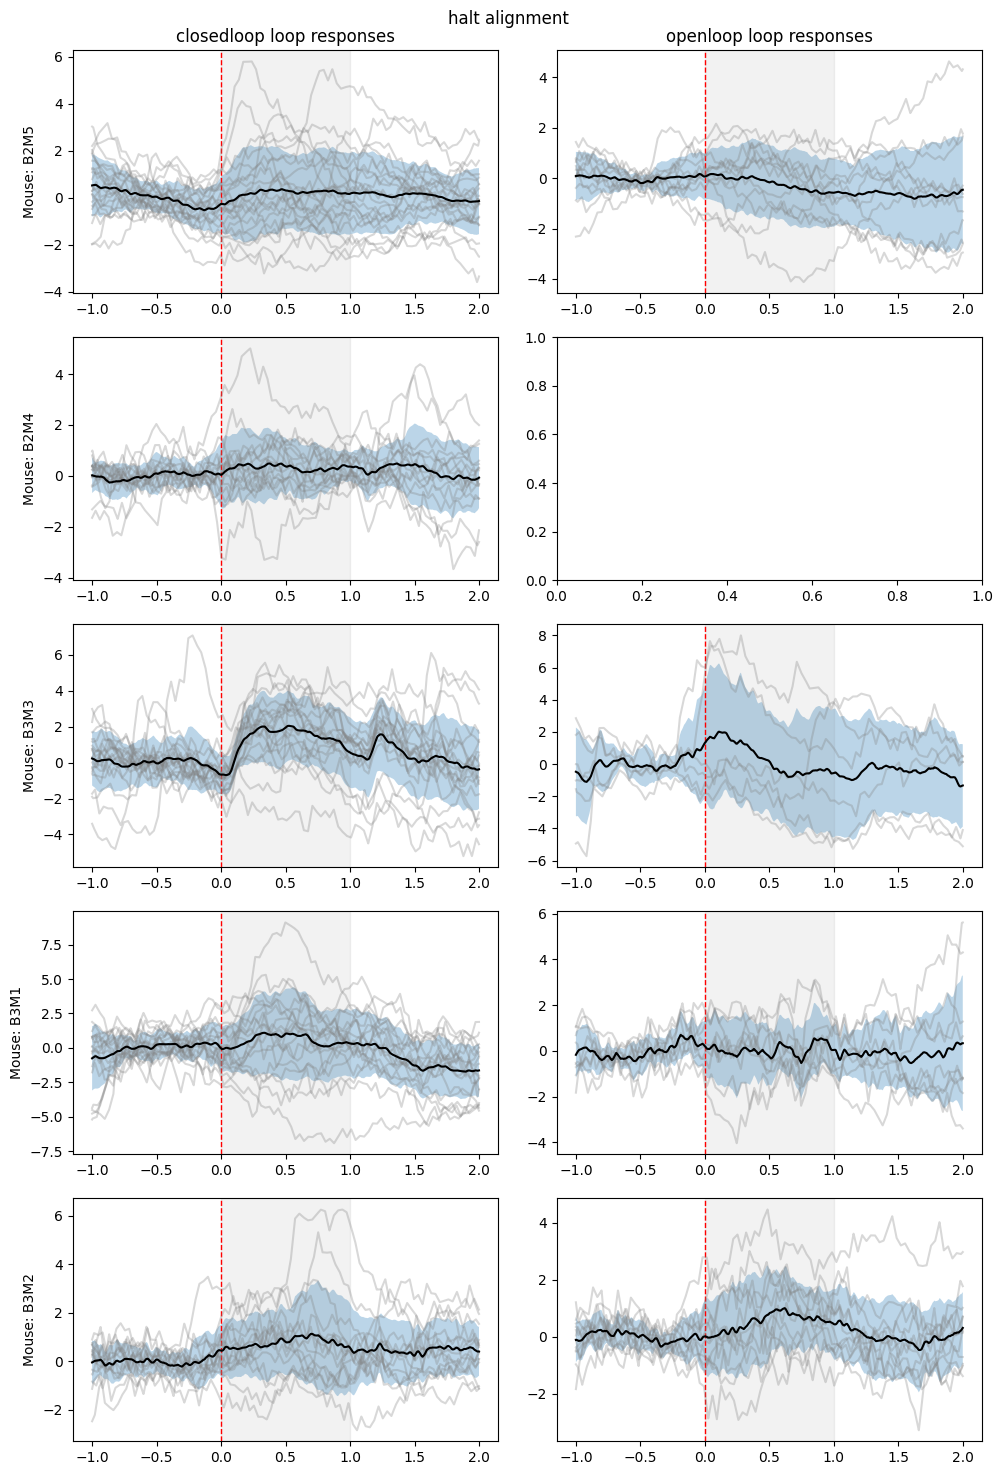

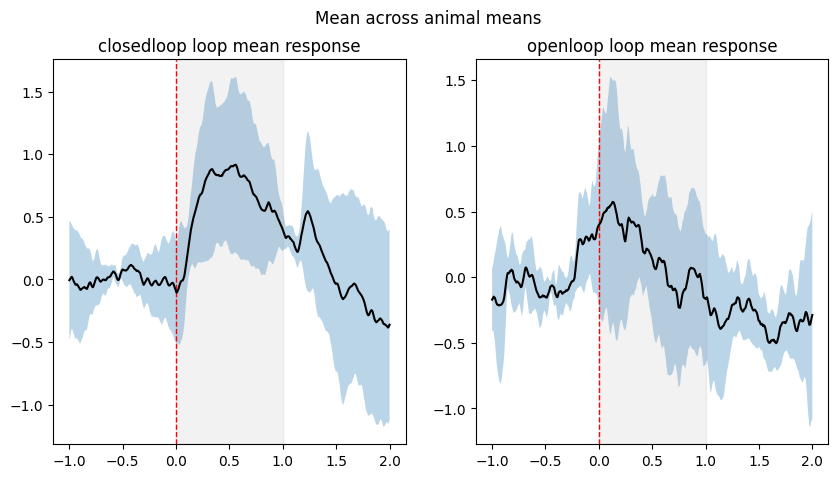

In [75]:
mean_mouse_dict_s1 =plot_compare_blocks(mouse_aligned['session 1'], 'halt')
mean_mouse_dict_s2 =plot_compare_blocks(mouse_aligned['session 2'], 'halt')

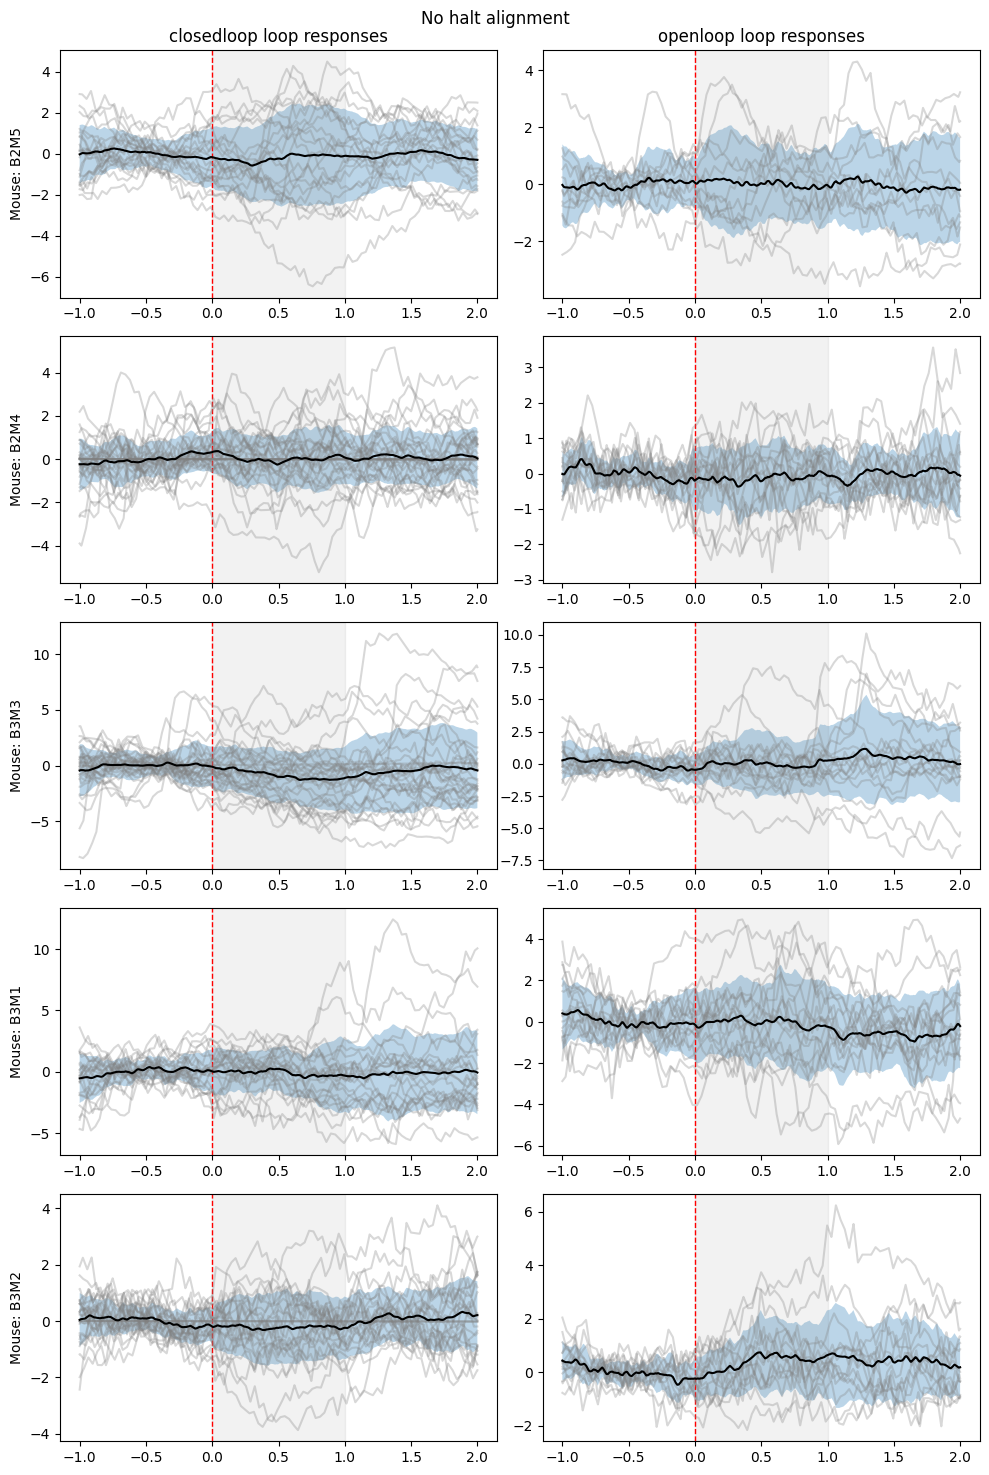

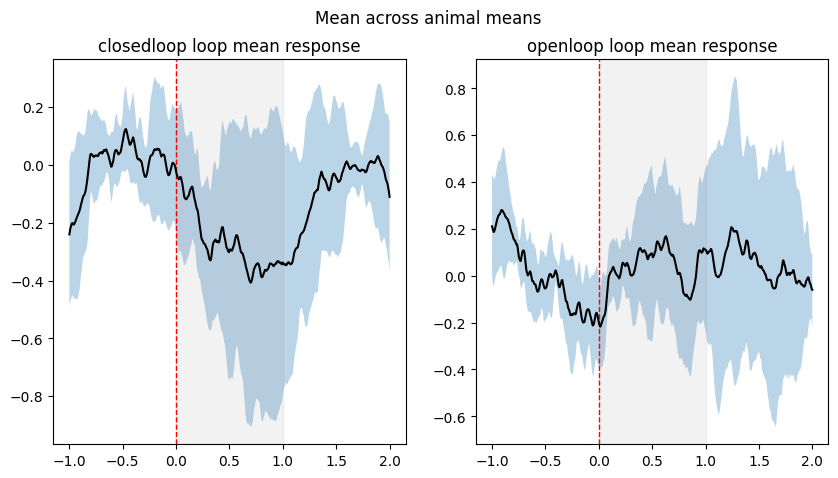

In [76]:
mean_mouse_dict_s1_nohalt =plot_compare_blocks(mouse_aligned_nohalt['session 1'], 'No halt')

In [ ]:
xtimes = [t for t in range(0, open_df.shape[0], round(open_df.shape[0] / 3))]
xtimes = [-1,0,1,2]

In [ ]:
from matplotlib import ticker
fig, ax = plt.subplots(5,2, figsize =(15,10))
ax =ax.flatten()
i=0
for mouse, closed_df in aligned_closed.items():
    open_df = aligned_open[mouse]
    plot = sns.heatmap(closed_df.T, ax = ax[i], yticklabels=False,xticklabels=False, cmap='gray')
    plot = sns.heatmap(open_df.T, ax = ax[i+1],yticklabels=False, cmap='gray')
    ax[0].set_xticks(xtimes)
    #ax[0].set_xticklabels([t for t in range(-1, 3 + 1, 1)], rotation = 0)


    i+=2